# American Sign Language Alphabet Recognition
## Final Project
### Machine Learning
### Maria Jose Millan Restrepo

In this project we are working with an image classification system focuses in the recognition of the American Sign Language Alphabet (ASL). The goal of this project, is to train and test multiple models of machine learning, and be able to identify correctly the letter represented by a hand gesture on an image.

Library necessary imports:

In [36]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import torch.nn as nn
import pandas as pd
import torchvision
from PIL import Image
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import joblib

%matplotlib inline
sns.set(style="whitegrid")

Describe a path for folders and create X and y:

In this project, the input data X corresponds to the pixel values of each image after resizing and normalization. Each image is converted into a numerical vector that represents the grayscale intensity of every pixel. The target variable y corresponds to the class label of each image, which is the letter of the American Sign Language (ASL) alphabet represented by the folder name where the image is stored.

In [37]:
base_dir = 'ASL/asl_alphabet_train/asl_alphabet_train'
X_list = []
y_list = []

for label_name in os.listdir(base_dir):
    label_dir = os.path.join(base_dir, label_name)
    if not os.path.isdir(label_dir):
        continue
    
    for fname in os.listdir(label_dir):
        fpath = os.path.join(label_dir, fname)
        img = Image.open(fpath).convert('L')  
        img = img.resize((28, 28))           
        arr = np.array(img).astype('float32') / 255.0
        X_list.append(arr.flatten())        
        y_list.append(label_name)       

X = np.array(X_list)
y = np.array(y_list)

The data used in this project is organized by folders, where each folder is representing a different class from the ASL alphabet and contains multiple images of that specific letter. Each image is processed and transformed into numerical data that can be recognized by the automated learning algorithms of the computer.

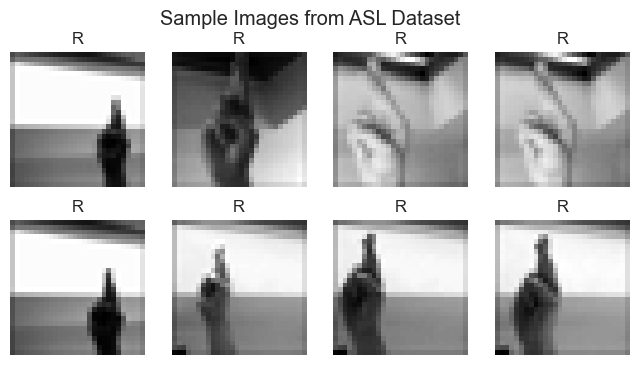

In [3]:
plt.figure(figsize=(8,4))

for i in range(8):
    plt.subplot(2,4,i+1)
    plt.imshow(X_list[i].reshape(28, 28), cmap='gray')
    plt.title(y_list[i])
    plt.axis('off')

plt.suptitle("Sample Images from ASL Dataset")
plt.show()

Throughout this project, I apply different preprocessing techniques, dimensionality reduction methods such as PCA, LDA, and t-SNE for visualization, and several classification models including k-NN, Multinomial Logistic Regression, Random Forest, Gradient Boosting, and a Convolutional Neural Network (CNN). Cross-validation is used to evaluate the models before final testing, and performance is measured using accuracy, confusion matrices, and F1-scores.

Preprocessing for classic models:

In [38]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

Separate data into train set and test set:

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y       
)
print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (69600, 784) Test: (17400, 784)


In [40]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

Dimensionality reduction:

### PCA (2D)

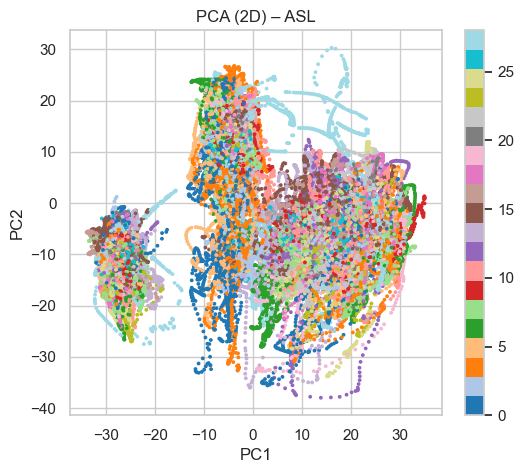

Explained Variance Ratio is 0.513


In [28]:
pca = PCA(n_components=2)
Xpca = pca.fit_transform(X_train_std)


plt.figure(figsize=(6,5))
plt.scatter(Xpca[:,0], Xpca[:,1], c=y_train, s=3, cmap='tab20')
plt.colorbar()
plt.title("PCA (2D) – ASL")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()
print(f'Explained Variance Ratio is {pca.explained_variance_ratio_[:2].sum() :.3}')

### LDA (2D)

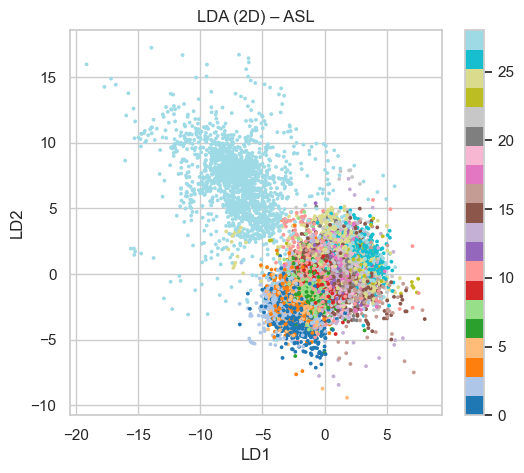

In [30]:
lda = LDA(n_components=2)
Xlda = lda.fit_transform(X_train_std, y_train)

plt.figure(figsize=(6,5))
plt.scatter(Xlda[:,0], Xlda[:,1], c=y_train, s=3, cmap='tab20')
plt.colorbar()
plt.title("LDA (2D) – ASL")
plt.xlabel("LD1")
plt.ylabel("LD2")
plt.show()

### t-SNE with perplexities = [5, 30, 50]

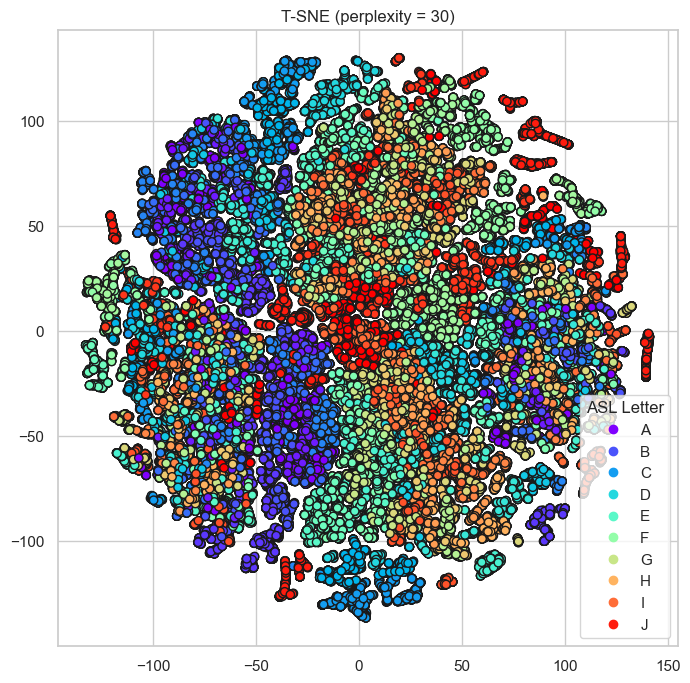

In [34]:
from sklearn.utils import resample

X_sample, y_sample = resample(X_train_std, y_train, n_samples=2000, random_state=42, stratify=y_train)

from sklearn.manifold import TSNE

X_tsne_30 = TSNE(perplexity=30, random_state=42).fit_transform(X_train_std)

plt.figure(figsize=(8,8))
ax = plt.scatter(x=X_tsne_30[:,0], y=X_tsne_30[:,1], c=y_train, cmap='rainbow', edgecolor='k')

plt.legend(ax.legend_elements(prop='colors')[0], le.classes_, title="ASL Letter")

plt.title("T-SNE (perplexity = 30)")
plt.show()

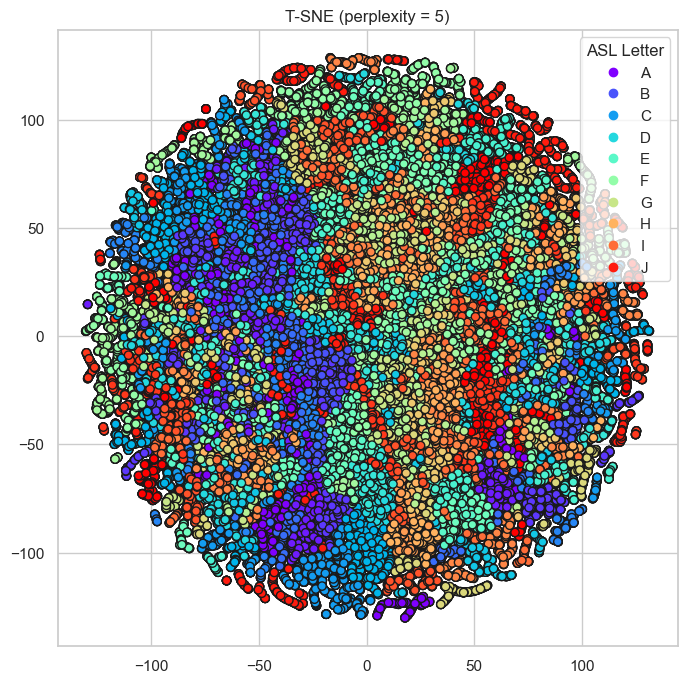

In [36]:
X_tsne_5 = TSNE(perplexity=5, random_state=42).fit_transform(X_train_std)

plt.figure(figsize=(8,8))
ax = plt.scatter(x=X_tsne_5[:,0], y=X_tsne_5[:,1], c=y_train, cmap='rainbow', edgecolor='k')

plt.legend(ax.legend_elements(prop='colors')[0], le.classes_, title="ASL Letter")

plt.title("T-SNE (perplexity = 5)")
plt.show()

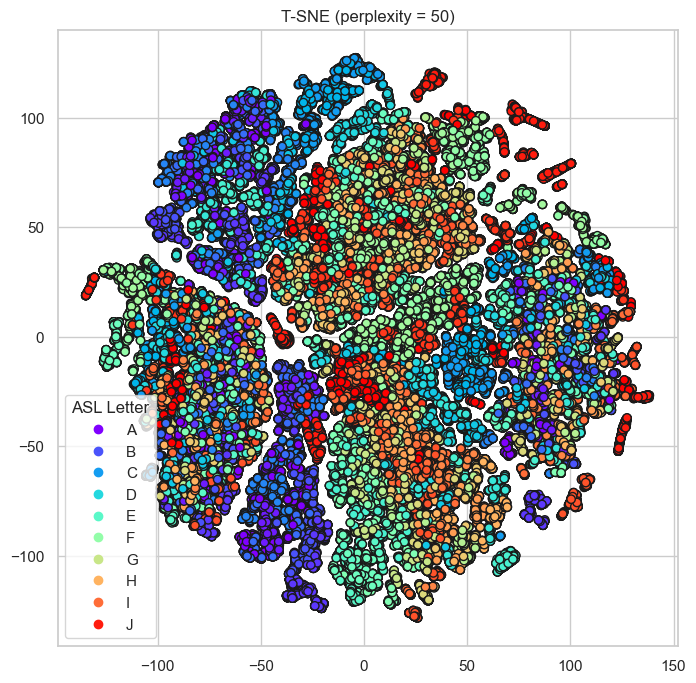

In [37]:
X_tsne_50 = TSNE(perplexity=50, random_state=42).fit_transform(X_train_std)

plt.figure(figsize=(8,8))
ax = plt.scatter(x=X_tsne_50[:,0], y=X_tsne_50[:,1], c=y_train, cmap='rainbow', edgecolor='k')

plt.legend(ax.legend_elements(prop='colors')[0], le.classes_, title="ASL Letter")

plt.title("T-SNE (perplexity = 50)")
plt.show()

Function to evaluate models:

In [41]:
def eval_model(model, X_train, X_test, y_train, y_test, name="Model"):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1  = f1_score(y_test, y_pred, average='weighted')
    
    print(f" {name}")
    print("Accuracy:", acc)
    print("F1 score (weighted):", f1)
    print("\nClassification report:\n", classification_report(y_test, y_pred))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, cmap='Purples')
    plt.xlabel("Predict")
    plt.ylabel("Real")
    plt.title(f"Confusion Matrix – {name}")
    plt.show()
    
    return model, y_pred, acc, f1

Classification models:

### k-NN

 k-NN (k=3)
Accuracy: 0.9910344827586207
F1 score (weighted): 0.9910311458729202

Classification report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       600
           1       0.99      0.99      0.99       600
           2       1.00      0.99      0.99       600
           3       0.99      1.00      1.00       600
           4       0.97      0.96      0.97       600
           5       1.00      1.00      1.00       600
           6       1.00      0.99      1.00       600
           7       1.00      1.00      1.00       600
           8       0.98      1.00      0.99       600
           9       0.99      0.99      0.99       600
          10       0.99      0.99      0.99       600
          11       1.00      1.00      1.00       600
          12       0.99      1.00      1.00       600
          13       1.00      1.00      1.00       600
          14       0.99      0.99      0.99       600
          15       1.00      

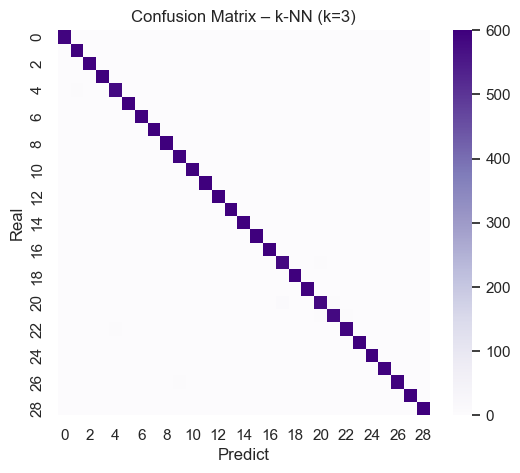

In [13]:
knn = KNeighborsClassifier(n_neighbors=3, metric='cosine')
knn_clf, knn_pred, knn_acc, knn_f1 = eval_model(knn, X_train_std, X_test_std, y_train, y_test, name="k-NN (k=3)")

In [46]:
y_pred = model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[600,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0, 597,   0,   0,   3,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  1,   4, 588,   7,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0, 600,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   7, 591,   2,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [  0,   0,   0,   1,   2, 597,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
    

In [27]:
import warnings
warnings.filterwarnings("ignore")

### Multinomial Logistic Regression

 Multinomial Logistic Regression
Accuracy: 0.8360919540229885
F1 score (weighted): 0.835613159721892

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77       600
           1       0.75      0.79      0.77       600
           2       0.86      0.85      0.85       600
           3       0.80      0.83      0.81       600
           4       0.78      0.73      0.75       600
           5       0.81      0.78      0.80       600
           6       0.89      0.86      0.88       600
           7       0.89      0.89      0.89       600
           8       0.88      0.93      0.90       600
           9       0.91      0.88      0.89       600
          10       0.89      0.91      0.90       600
          11       0.90      0.91      0.90       600
          12       0.83      0.83      0.83       600
          13       0.90      0.87      0.89       600
          14       0.84      0.86      0.85       600
         

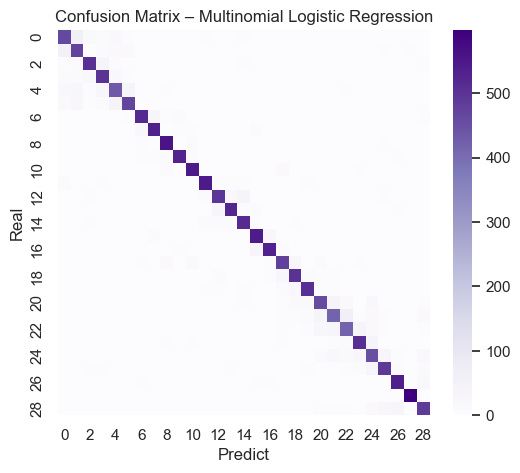

In [28]:
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, n_jobs=-1)
log_clf, log_pred, log_acc, log_f1 = eval_model(log_reg, X_train_std, X_test_std, y_train, y_test,n name="Multinomial Logistic Regression")

### Random Forest

 Random Forest
Accuracy: 0.9962068965517241
F1 score (weighted): 0.9962067809468392

Classification report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       600
           1       0.99      0.99      0.99       600
           2       1.00      0.98      0.99       600
           3       0.98      1.00      0.99       600
           4       0.99      0.98      0.99       600
           5       1.00      0.99      1.00       600
           6       1.00      1.00      1.00       600
           7       1.00      1.00      1.00       600
           8       1.00      1.00      1.00       600
           9       1.00      1.00      1.00       600
          10       1.00      1.00      1.00       600
          11       1.00      1.00      1.00       600
          12       1.00      1.00      1.00       600
          13       1.00      1.00      1.00       600
          14       1.00      1.00      1.00       600
          15       1.00   

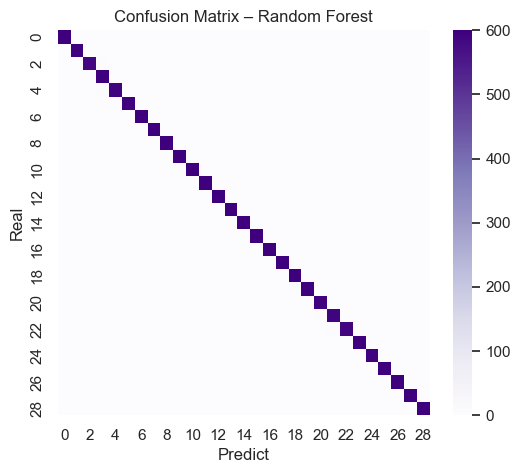

In [29]:
rf = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42, n_jobs=-1)
rf_clf, rf_pred, rf_acc, rf_f1 = eval_model(rf, X_train, X_test, y_train, y_test, name="Random Forest")

### Gradient Boost

In [ ]:
gb = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=3, random_state=42)
gb_clf, gb_pred, gb_acc, gb_f1 = eval_model(gb, X_train, X_test, y_train, y_test,name="Gradient Boost")

### Cross Validation

In [33]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model, X_use in [("Logistic Regression", log_reg, X_train_std),("Random Forest", rf, X_train)]:
    scores = cross_val_score(model, X_use, y_train, cv=cv, scoring='accuracy', n_jobs=-1)
    print(f"{name} – Cross-validation")
    print("Scores per fold:", scores)
    print("Mean accuracy:", scores.mean())
    print("Std:", scores.std(), "\n")

Logistic Regression – Cross-validation
Scores per fold: [0.82112069 0.82931034 0.82385057 0.82420977 0.81875   ]
Mean accuracy: 0.8234482758620689
Std: 0.0035382770961429667 

Random Forest – Cross-validation
Scores per fold: [0.99382184 0.9941092  0.99468391 0.99554598 0.9941092 ]
Mean accuracy: 0.9944540229885058
Std: 0.0006136251868983805 



### Results Summary Table

In [32]:
results = pd.DataFrame({
    "Model": ["k-NN (k=3)","Logistic Multinomial Regrassion", "Random Forest"],
    "Accuracy": [knn_acc, log_acc, rf_acc],
    "F1_weighted": [knn_f1, log_f1, rf_f1]})

display(results)

,Model,Accuracy,F1_weighted
0,k-NN (k=3),0.978678,0.978655
1,Logistic Multinomial Regrassion,0.836092,0.835613
2,Random Forest,0.996207,0.996207
